# **System Dynamics II Report**
Team 6 Members:

Cole Brauer @ cbrauer@asu.edu

Fuchen Chen @ fchen65@asu.edu

Nathaniel Rossi @ ntrossi@asu.edu

Mason Smith @ mosmith3@asu.edu

## Install Dependancies and Import Packages

In [ ]:
!pip install pynamics

In [ ]:
%matplotlib inline

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.constraint import Constraint
from pynamics.dyadic import Dyadic
from pynamics.output import PointsOutput
from pynamics.particle import Particle
from pynamics.body import Body
import pynamics.integration

import sympy
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from IPython.display import display, clear_output, HTML
import time
import csv

In [ ]:
# Unit scaling
M_TO_L = 1e3 # mm
KG_TO_W = 1e3 # g
S_TO_T = 1e1 # 0.1s
DEG_TO_RAD = pi/180

# Simulation settings
tol = 1e-9
fps = 30
tfinal = 0.5*S_TO_T

system = System()
pynamics.set_system(__name__,system)

## **1. System Definition**

To achieve a stable landing motion, our system takes inspiration from the structure of the kangaroo rat. Kangaroo rats’ hind limbs allow them to perform repetitive, high-speed jumping and landing motions and are of a similar scale to the target system size.

A literature review on work regarding kangaroo rats' motion was presented in "Biomechanics Background and Initial Specification" [1]. Table 1 summarizes the key parameters of a kangaroo rat that were identified during this review. In addition, measurements of the bones in kangaroo rats' limbs were found.

_Table 1: Reviewed Biological Parameters_

| Parameter                  | Units | Value Range |
|----------------------------|-------|-------------|
| Total mass                 | kg    | 0.072-0.120 |
| Takeoff/Touchdown velocity | m/s   | 0.9-3.1     |
| Hopping peak ground force  | N     | 2.5         |
| Hopping positive work      | J     | 0.075       |
| Jumping height             | m     | 0.1-0.4     |
| Jumping peak ground force  | N     | 3-5         |
| Jumping total joint work   | J     | 0.1-0.3     |

Based on the skeletal structure of kangaroo rats' limbs, the system shown in Figure 1 was designed. This system consists of two five-bar linkages in series. Links A, E, and G closely follow the geometry of a kangaroo rat leg. Links B, C, D, and F were added to simulate the function of the tendons that control the motion of the leg. Table 2 lists the lengths selected for each link based on background literature.

_Figure 1: System Kinematics Diagram_

![device diagram](https://drive.google.com/uc?export=download&id=1sU-75v1phYr4LI2kyyFs5HR_BeY2cwNV)

_Table 2: System Link Lengths_

| Link     | Length |
|----------|--------|
| $l_N$    | 15 mm  |
| $l_{A1}$ | 10 mm  |
| $l_{A2}$ | 17 mm  |
| $l_B$    | 10 mm  |
| $l_C$    | 20 mm  |
| $l_{D1}$ | 20 mm  |
| $l_{D2}$ | 25 mm  |
| $l_E$    | 46 mm  |
| $l_F$    | 10 mm  |
| $l_{G1}$ | 10 mm  |
| $l_{G2}$ | 32 mm  |

In this system, $q_A$ and $q_B$ represent input joints that can be used to control the pose of the leg. Because the focus of this work is the passive response of the system to an impact load, fixed values for $q_A$ and $q_B$ were selected. The initial values for the remaining angles were found using a numeric solution [2]. Table 2 lists the initial conditions for each state variable.

_Table 2: State Variable Initial Conditions_

| State Variable | Value     |
|----------------|-----------|
| $q_A$          | -0.44 rad |
| $q_B$          | -2.36 rad |
| $q_C$          |  1.77 rad |
| $q_D$          | -1.94 rad |
| $q_E$          | -1.88 rad |
| $q_F$          |  1.57 rad |
| $q_G$          |  0.55 rad |

Other important variables for simulating the system dynamics include the link dimensions, system mass, and drop test conditions. Several relevant values are listed in Table 3. The link width and thickness were selected based on the available construction materials. The link density was defined as the density of PLA plastic, which is the predominant structural material. The linkage mass was calculated based on the material volume and density. Finally, the payload mass and drop height were selected based on the values in Table 3.

_Table 3: Other System Properties_

| Variable       | Value     |
|----------------|-----------|
| Link Width     | 30 mm     |
| Link Thickness | 3 mm      |
| Link Density   | 0.00124 g/mm$^3$ |
| Linkage Mass   | 0.033 g   |
| Payload Mass   | 0.023 g   |
| Drop Height    | 0.1 m     |

The first five-bar linkage is fully constrained by the two input joints. The second five-bar has a single degree of freedom which simulates the motion resulting from compliance in the ankle tendons of a kangaroo rat. To provide the desired behavior on impact, the joint at $p_{FG}$ was designed to include laminate layers with damped and elastic properties. This joint was selected because it undergoes a higher displacement than others during an impact with the ground. This allows for better control of the joint's behavior. The remaining joints are constructed using only flexible materials to minimize the number of variables affecting the system dynamics.

In [ ]:
# Drop height
h_drop = 0.1*M_TO_L

# Initial joint angle
qP_i = -0*DEG_TO_RAD
qA_i = -25*DEG_TO_RAD 
qB_i = -135*DEG_TO_RAD
qC_i = 1.7737409743635988
qD_i = -1.9405628086550872
qG_i = 60*DEG_TO_RAD
qH_i = 0*DEG_TO_RAD
    
# Density of link, PLA
rho = 1240*KG_TO_W/M_TO_L**3 

# Payload dimension
lp_v = 0.02*M_TO_L # length
wp_v = 0.03*M_TO_L # width
tp_v = 0.01*M_TO_L # thickness

# Link dimension
w_v = 0.03*M_TO_L # width
t_v = 0.003*M_TO_L # thickness

ln_v = 0.015*M_TO_L # length
la1_v = 0.010*M_TO_L
la2_v = 0.017*M_TO_L
lb_v = 0.010*M_TO_L
lc_v = 0.020*M_TO_L
ld1_v = 0.020*M_TO_L
ld2_v = 0.025*M_TO_L
le_v = 0.046*M_TO_L
lf_v = 0.010*M_TO_L
lg1_v = 0.010*M_TO_L
lg2_v = 0.020*M_TO_L
lh_v = 0.012*M_TO_L

# Mass
mP_v = lp_v*wp_v*tp_v*rho
mA_v = (la1_v+la2_v)*w_v*t_v*rho
mB_v = lb_v*w_v*t_v*rho
mC_v = lc_v*w_v*t_v*rho
mD_v = (ld1_v+ld2_v)*w_v*t_v*rho
mE_v = le_v*w_v*t_v*rho
mF_v = lf_v*w_v*t_v*rho
mG_v = (lg1_v+lg2_v)*w_v*t_v*rho
mH_v = lh_v*w_v*t_v*rho

print('Payload mass', mP_v)
print('Total mass', mP_v+mA_v+mB_v+mC_v+mD_v+mE_v+mF_v+mG_v+mH_v)

Payload mass 7.44
Total mass 29.759999999999998


In [ ]:
# Intertias 
# Each link is considered as a box with uniform density
Ixx_P = Constant(mP_v*(wp_v**2+tp_v**2)/12, 'Ixx_P', system)
Iyy_P = Constant(mP_v*(lp_v**2+wp_v**2)/12, 'Iyy_P', system)
Izz_P = Constant(mP_v*(lp_v**2+tp_v**2)/12, 'Izz_P', system)

Ixx_A = Constant(mA_v*(w_v**2+t_v**2)/12, 'Ixx_A', system)
Iyy_A = Constant(mA_v*((la1_v+la2_v)**2+w_v**2)/12, 'Iyy_A', system)
Izz_A = Constant(mA_v*((la1_v+la2_v)**2+t_v**2)/12, 'Izz_A', system)

Ixx_B = Constant(mB_v*(w_v**2+t_v**2)/12, 'Ixx_B', system)
Iyy_B = Constant(mB_v*(lb_v**2+w_v**2)/12, 'Iyy_B', system)
Izz_B = Constant(mB_v*(lb_v**2+t_v**2)/12, 'Izz_B', system)

Ixx_C = Constant(mC_v*(w_v**2+t_v**2)/12, 'Ixx_C', system)
Iyy_C = Constant(mC_v*(lc_v**2+w_v**2)/12, 'Iyy_C', system)
Izz_C = Constant(mC_v*(lc_v**2+t_v**2)/12, 'Izz_C', system)

Ixx_C = Constant(mC_v*(w_v**2+t_v**2)/12, 'Ixx_C', system)
Iyy_C = Constant(mC_v*(lc_v**2+w_v**2)/12, 'Iyy_C', system)
Izz_C = Constant(mC_v*(lc_v**2+t_v**2)/12, 'Izz_C', system)

Ixx_D = Constant(mD_v*(w_v**2+t_v**2)/12, 'Ixx_D', system)
Iyy_D = Constant(mD_v*((ld1_v+ld2_v)**2+w_v**2)/12, 'Iyy_D', system)
Izz_D = Constant(mD_v*((ld1_v+ld2_v)**2+t_v**2)/12, 'Izz_D', system)

Ixx_E = Constant(mE_v*(w_v**2+t_v**2)/12, 'Ixx_E', system)
Iyy_E = Constant(mE_v*(le_v**2+w_v**2)/12, 'Iyy_E', system)
Izz_E = Constant(mE_v*(le_v**2+t_v**2)/12, 'Izz_E', system)

Ixx_F = Constant(mF_v*(w_v**2+t_v**2)/12, 'Ixx_F', system)
Iyy_F = Constant(mF_v*(lf_v**2+w_v**2)/12, 'Iyy_F', system)
Izz_F = Constant(mF_v*(lf_v**2+t_v**2)/12, 'Izz_F', system)

Ixx_G = Constant(mG_v*(w_v**2+t_v**2)/12, 'Ixx_G', system)
Iyy_G = Constant(mG_v*((lg1_v+lg2_v)**2+w_v**2)/12, 'Iyy_G', system)
Izz_G = Constant(mG_v*((lg1_v+lg2_v)**2+t_v**2)/12, 'Izz_G', system)

Ixx_H = Constant(mH_v*(w_v**2+t_v**2)/12, 'Ixx_H', system)
Iyy_H = Constant(mH_v*(lh_v**2+w_v**2)/12, 'Iyy_H', system)
Izz_H = Constant(mH_v*(lh_v**2+t_v**2)/12, 'Izz_H', system)

In [ ]:
# Constants
lp = Constant(lp_v,'lp',system)
tp = Constant(tp_v,'tp',system)
ln = Constant(ln_v,'ln',system)
la1 = Constant(la1_v,'la1',system)
la2 = Constant(la2_v,'la2',system)
lb = Constant(lb_v,'lb',system)
lc = Constant(lc_v,'lc',system)
ld1 = Constant(ld1_v,'ld1',system)
ld2 = Constant(ld2_v,'ld2',system)
le = Constant(le_v,'le',system)
lf = Constant(lf_v,'lf',system)
lg1 = Constant(lg1_v,'lg1',system)
lg2 = Constant(lg2_v,'lg2',system)
lh = Constant(lh_v,'lh',system)

mP = Constant(mP_v,'mP',system)
mA = Constant(mA_v,'mA',system)
mB = Constant(mB_v,'mB',system)
mC = Constant(mC_v,'mC',system)
mD = Constant(mD_v,'mD',system)
mE = Constant(mE_v,'mE',system)
mF = Constant(mF_v,'mF',system)
mG = Constant(mG_v,'mG',system)
mH = Constant(mH_v,'mH',system)

# Gravity
g = Constant(9.81*M_TO_L/S_TO_T**2,'g',system) # m/s^2

In [ ]:
# Payload linear and angular varibales
xP,xP_d,xP_dd = Differentiable('xP',system)
yP,yP_d,yP_dd = Differentiable('yP',system)
qP,qP_d,qP_dd = Differentiable('qP',system)

# Linkage angular variables
qA = Constant(qA_i,'qA',system) # These angles are constant to simplify the model
qB = Constant(qB_i,'qB',system)
qC = Constant(qC_i,'qC',system)
qD = Constant(qD_i,'qD',system)

qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)
qH,qH_d,qH_dd = Differentiable('qH',system)

qG1 = pi-(3*pi-(pi+qE)-(pi-qF)-(pi-qG)-(-qD))

# Frames
N = Frame('N')
P = Frame('P')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')
G = Frame('G')
H = Frame('H')
G1 = Frame('G1')

system.set_newtonian(N)
state_variables = system.get_state_variables()

In [ ]:
# Kinemactics
P.rotate_fixed_axis_directed(N,[0,0,1],qP,system)
A.rotate_fixed_axis_directed(P,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(P,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(A,[0,0,1],qD,system)
E.rotate_fixed_axis_directed(A,[0,0,1],qE,system)
F.rotate_fixed_axis_directed(D,[0,0,1],qF,system)
G.rotate_fixed_axis_directed(F,[0,0,1],qG,system)
H.rotate_fixed_axis_directed(G,[0,0,1],qH,system)
G1.rotate_fixed_axis_directed(G,[0,0,1],qG1,system)

# Joints
pNP = xP*N.x+yP*N.y
pNA = pNP+0*P.x
pNB = pNP-ln*P.x
pNC = pNB + lb*B.x
pND = pNA + la1*A.x
pND1 = pNC + lc*C.x
pND1_p = pND + ld1*D.x
pNE = pNA + (la1+la2)*A.x
pNF= pND + (ld1+ld2)*D.x
pNG = pNF + lf*F.x
pNG1 = pNG + lg1*G.x
pNG1_p = pNE + le*E.x
pNH = pNG+(lg1+lg2)*G.x 
pNI = pNH+lh*H.x # Toe

# Payload
pNPC = pNP-ln/2*P.x # Center
pNP1 = pNPC-lp/2*P.x+tp/2*P.y # top left
pNP2 = pNPC+lp/2*P.x+tp/2*P.y # top right
pNP3 = pNPC+lp/2*P.x-tp/2*P.y # bottom right
pNP4 = pNPC-lp/2*P.x-tp/2*P.y # bottom left

# Center of mass
pPm = pNPC
pAm = pNA + (la1+la2)/2*A.x
pBm = pNB + lb/2*B.x
pCm = pNC + lc/2*C.x
pDm = pND + (ld1+ld2)/2*D.x
pEm = pNE + le/2*E.x
pFm = pNF + lf/2*F.x
pGm = pNG + (lg1+lg2)/2*G.x
pHm = pNH + lh/2*H.x

In [ ]:
# Constraints
eq = [
#     xP, yP-h_drop, qP-qP_i,
#     qA-qA_i, qB-qB_i, 
#     qG-qG_i, 
    qH-qH_i, # Prevent toe from bending for now   
    (pNG1-pNG1_p).dot(P.x),
    (pNG1-pNG1_p).dot(P.y),
] 
eq_d=[(system.derivative(e)) for e in eq]
eq_dd=[(system.derivative(e)) for e in eq_d]

2021-03-20 04:11:11,220 - pynamics.output - INFO - calculating outputs
2021-03-20 04:11:11,224 - pynamics.output - INFO - done calculating outputs


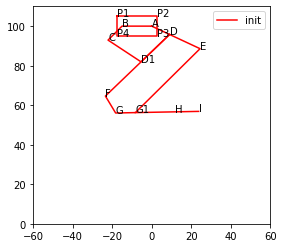

In [ ]:
# Initial position solver and plotter
# Numerically solve for position of the points based on inputs
def solve_position(qi,qd,points):
    c = Constraint(eq)
    
    # Make qi constant beacuse it is the input in fk
    constants = system.constant_values.copy()
    constants.update(dict([(q,qi[q]) for q in qi]))

    variables = list(qi.keys())+list(qd.keys())
    guess = []
    for v in variables:
        if v in qi: 
            guess.append(qi[v])
        elif v in qd:  
            guess.append(qd[v])
        else:
            guess.append(0)
    result = c.solve_numeric(variables,guess,constants) # Solve based on added constants

    sv_values = []
    for sv in system.get_state_variables():
        if sv in variables:
            sv_values.append(result.x[variables.index(sv)])
        else:
            sv_values.append(0) # Assume zero speed, will not affect point locations
    
    points_output = PointsOutput(points, constant_values=system.constant_values)
    points_output.calc(np.array([sv_values,sv_values]))
        
    x = {}
    for i, v in enumerate(variables):
        x[v] = result.x[i]

    return x, points_output.y[0,:,:]

def plot(ps, c='r', l='test'):
    ps_ADD1CB = np.array([
        ps[0,:],
        ps[3,:],
        ps[4,:],
        ps[2,:],
        ps[1,:],
        ps[0,:],
    ])
    ps_DEG1GF = np.array([
        ps[3,:],
        ps[5,:],
        ps[8,:],
        ps[7,:],
        ps[6,:],
        ps[3,:],
    ])    
    ps_G1HI = np.array([
        ps[8,:],
        ps[9,:],
        ps[10,:]
    ])    
    ps_P1P2P3P4 = np.array([
        ps[11,:],
        ps[12,:],
        ps[13,:],
        ps[14,:],
        ps[11,:]
    ])       

    plt.plot(ps_P1P2P3P4[:,0],ps_P1P2P3P4[:,1],c)
    for p, label in zip(ps_P1P2P3P4[:-1,:],['P1','P2','P3','P4']):
        plt.text(p[0],p[1],label)
             
    plt.plot(ps_ADD1CB[:,0],ps_ADD1CB[:,1],c)
    for p, label in zip(ps_ADD1CB[:-1,:],['A','D','D1','C','B']):
        plt.text(p[0],p[1],label)
        
    plt.plot(ps_DEG1GF[:,0],ps_DEG1GF[:,1],c)
    for p, label in zip(ps_DEG1GF[1:-1,:],['E','G1','G','F']):
        plt.text(p[0],p[1],label)
        
    plt.plot(ps_G1HI[:,0],ps_G1HI[:,1],c)
    for p, label in zip(ps_G1HI[1:,:],['H','I']):
        plt.text(p[0],p[1],label)
    
    plt.plot([],c,label=l)
    plt.axis('scaled')
    plt.xlim(-0.06*M_TO_L,0.06*M_TO_L)
    plt.ylim(-0.0*M_TO_L,h_drop+0.01*M_TO_L)
    plt.legend()
    
points_plot = [pNA,pNB,pNC,pND,pND1,pNE,pNF,pNG,pNG1,pNH,pNI,pNP1,pNP2,pNP3,pNP4]

# Test Plots
qs1,ps1 = solve_position(
    {xP:0, yP:h_drop, qP:qP_i, qG:qG_i, qH:qH_i}, # Input value
    {qF:90*DEG_TO_RAD, qE:-90*DEG_TO_RAD}, # Guess values
    points_plot # Points to calculate, use this order to ensure plot is correct
)

plt.figure()
plot(ps1, c='r', l='init')

## **2. Material Parameterization**



Four materials were chosen to be the laminate material that compose the joints of the leg; transparency film, a polycarbonate sheet, high density polyurethane foam, and rubber.  These materials were chosen based upon their availability and varying material properties.  Mainly, the materials were likely to have a range of different damping coefficients that can be used to explore what type material would be best to achieve the desired behavior during impact. Since this research is investigating the passive damping at a specific "actuator" joint, the transparency film will be used as the control material and used for all other joints.  However, simulations were still performed with the transparency film at the actuator joint as a control.
 
All materials properties were fitted by first observing the angular displacement over time in an experimental pendulum setup seen in Figure 3. Then, the theoretical values for both the spring and damping coefficients were found by optimizing these values such that the simulated dynamics would match the observed angular displacement. The code that optimizes for the theoretical values can be found in Section 2.1 while the results from the optimization process for each material can be found in Sections 2.2-2.5.

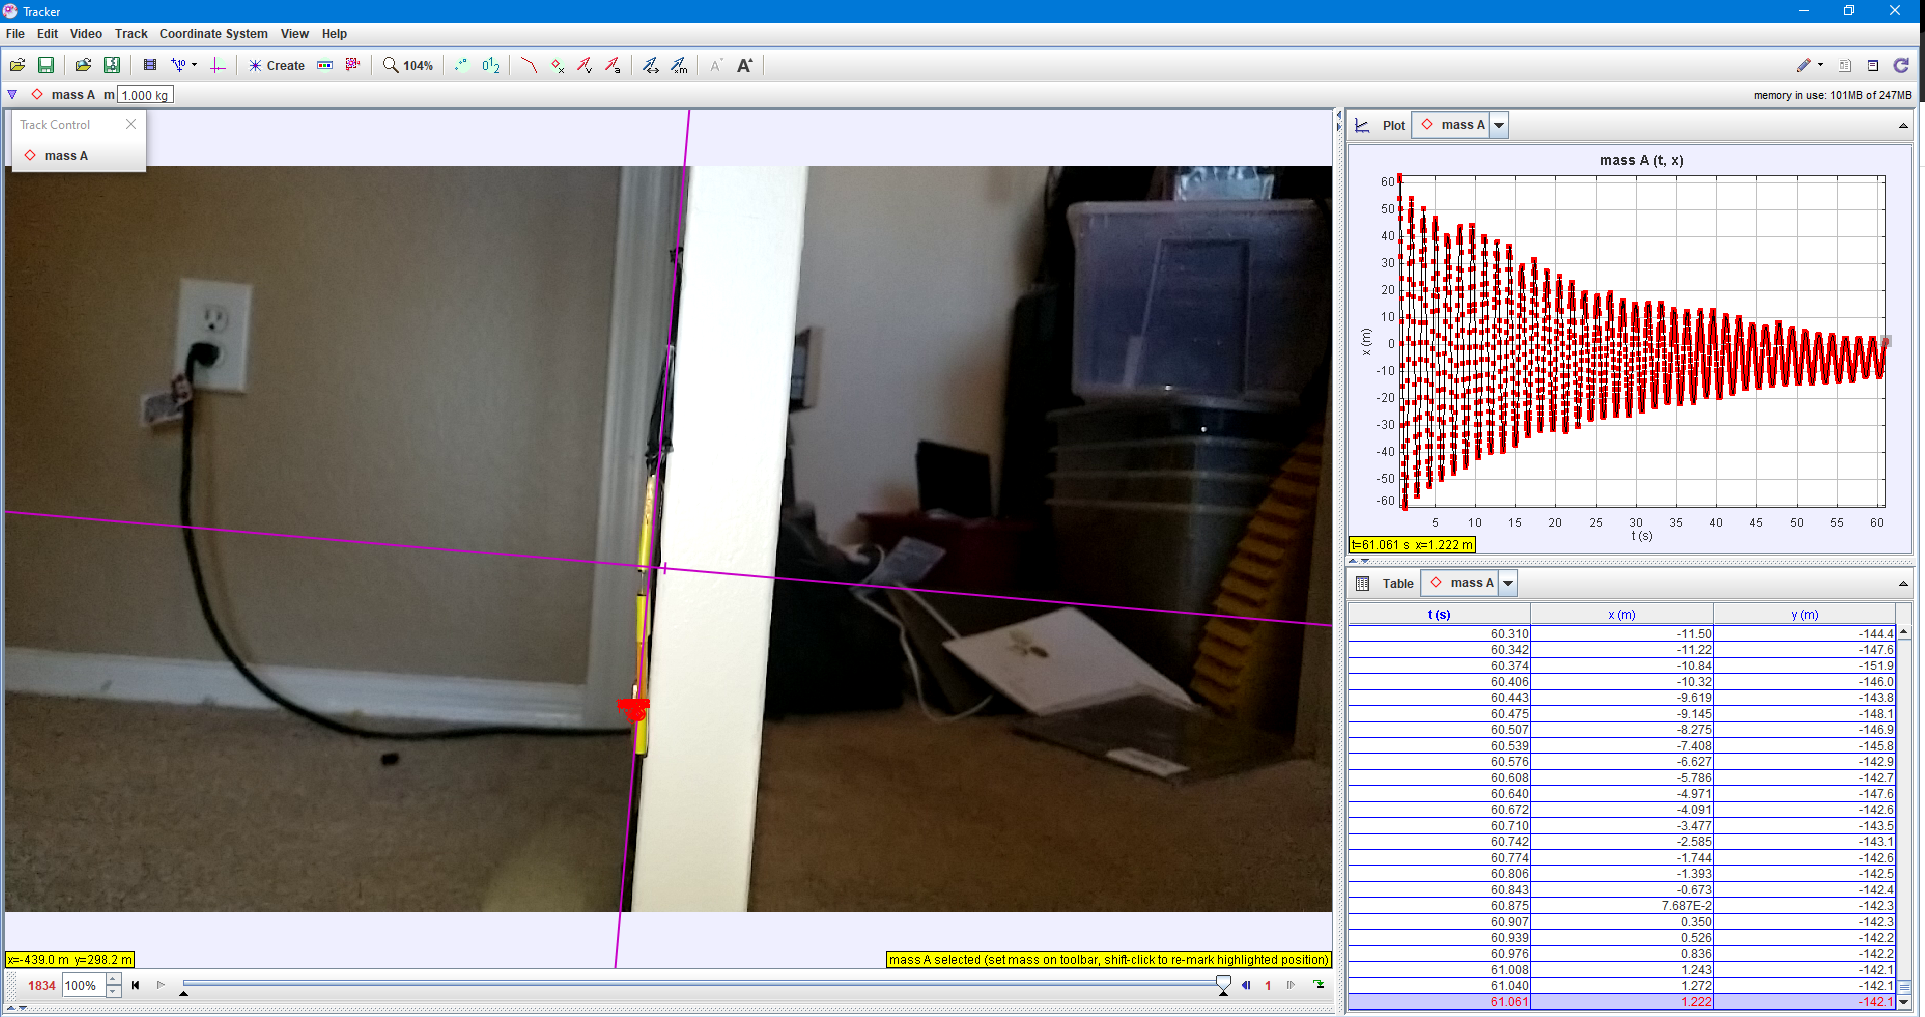


Figure 3: Experimental Pendulum Setup with Transparancy Film

### 2.1 Parameterization Code
To avoid varibles with same names and reduce the length of this report, the codes used for parameterization are attached as seprate files. 

### 2.2 Polycarbonate Results


In [ ]:
polycarb_properties = {
    "mass": 0.008,        # mass of 3D printed parts as a weight(kg)
    "l_mass": 0.046,        # length from pivot to mass (meters)
    "l_material": 0.003,   # length of material on joint
    "w_material": 0.03,   # w_material of material at joint
    "h_material": 0.0008,  # thickness of material at joint
    "gravity": 9.81,       # m/s
    "damping_guess": 0.9e-5, # Initial guess for optimization
    "spring_guess":  8e-2,   # Initial guess for optimization
    "Damping constant": 7.047049726701318e-05, # Optimized result
    "Spring constant": 0.0007056933111782472 # Optimized result
}

The polycarbonate was too rigid to the point of it not being able to rotate more than 27° with the 3D printed plates. In addition, the material rotated at such a high frequency that a 60fps camera was unable to differentiate where the object was located as seen in figure 5. As a result, the data that was outputted from Tracker was considered too noisy for proper analysis and was eliminated as a potential damping material for the final mechanism.

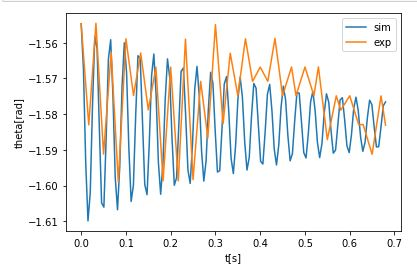

Figure 4: Polycarbonate Spring and Damping  Constants Response (Guess)

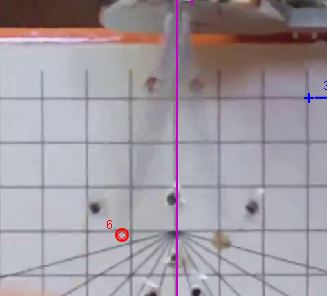

Figure 5: Experimental Pendulum Setup with polycarbonate

### 2.3 Rubber Results

In [ ]:
rubber_properties = {
    "mass": 0.0295,        #
    "l_mass": 0.0775,        # length from pivot to mass (meters)
    "l_material": 0.005,   # length of material on joint
    "w_material": 0.030,   # w_material of material at joint
    "h_material": 0.00476,  # thickness of material at joint
    "gravity": 9.81,       # m/s
    "damping_guess": 0.00015, # Initial guess for optimization
    "spring_guess": 0.008,   # Initial guess for optimization
    "k": 0.011019806929039436, # Optimized result
    "b": 0.00014515254240395263 # Optimized result
}

![plot1](https://drive.google.com/uc?export=download&id=1CdVpspsfNUBREkxorhLsGO_3gVC4bZSw)

Figure 6: Rubber Spring and Damping Constants Response (Guess)

![plot2](https://drive.google.com/uc?export=download&id=17QjpO8Hwa4g9821RX3EUxeHhU9jMOwpD)

Figure 7: Rubber Spring and Damping Constants Response (Optimized)

### 2.4 Transparency Film Results 

In [ ]:
transparancy_properties = {
    "mass": 0.0025,        # Used a dime as a weight (kg)
    "l_mass": 0.04,        # length from pivot to mass (meters)
    "l_material": 0.006,   # length of material on joint
    "w_material": 0.021,   # w_material of material at joint
    "h_material": 0.0004,  # thickness of material at joint
    "gravity": 9.81,       # m/s
    "damping_guess": 1.3e-6, # Initial guess for optimization
    "spring_guess":  1e-3,   # Initial guess for optimization
    "b": 3.211597004593089e-06, # Optimized result
    "k": 0.003867386434870078 # Optimized result
}

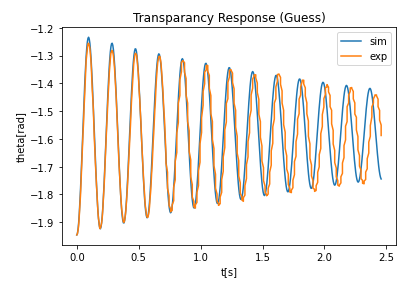

Figure 8: Transparancy Film Spring and Damping Constants Response (Guess)

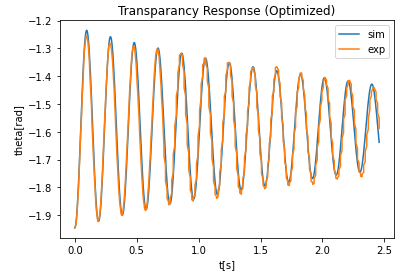

Figure 9: Transparancy Film Spring and Damping Constants Response (Optimized)

### 2.5 Polyuerthane Foam Results

In [ ]:
polyuerthane_properties = {
    "mass": 0.0025,        # PLA link mass (kg)
    "l_mass": 0.02,        # length from pivot to mass center (meters)
    "l_material": 0.003,   # length of material on joint
    "w_material": 0.030,   # w_material of material at joint    
    "h_material": 0.0008,  # thickness of material at joint
    "gravity": 9.81,       # m/s^2
    "damping_guess": 1e-5, # Initial guess for optimization
    "spring_guess":  5e-4,   # Initial guess for optimization
    "b": 8.295479714555005e-06, # Optimized result
    "k": 0.0009937690707882902 # Optimized result
}

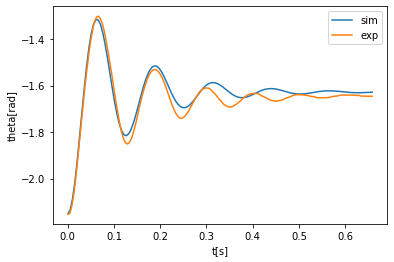

Figure 10: Polyuerthane Foam Spring and Damping Constants Response (Optimized)

In [ ]:
# Damping and spring constant
# angular damping, kg*m/s^2*m/(rad/s)
# angular spring constant, kg*m/s^2*m/rad

# Joint G, "actuator" joint
b = Constant(1e-5*KG_TO_W*M_TO_L**2/S_TO_T,'b',system)
k = Constant(1e-2*KG_TO_W*M_TO_L**2/S_TO_T**2,'k',system)

# Joint H, toe joint
# bh = Constant(1e-5*KG_TO_W*M_TO_L**2/S_TO_T,'bh',system)
# kh = Constant(1e-2*KG_TO_W*M_TO_L**2/S_TO_T**2,'kh',system) 

# Other joints
bj = Constant(1e-5*KG_TO_W*M_TO_L**2/S_TO_T,'bj',system)
kj = Constant(1e-2*KG_TO_W*M_TO_L**2/S_TO_T**2,'kj',system)

## **3. Forces Considerations**

### Joint Forces
Each joint (E, F, G, G1) is modelled as a spring and damper. The passive joint G have different coefficients from other joints since it is designed to be the main impact attenuator. The resting angle of the joint springs are set to the initial joint angles calculated above. 

### Contact Forces
The floor is modelled as a spring and a damper only in effect when touching. The force is proportional to the distance of the contact points passing the floor. Contact forces only apply to the point G, G1, H, and I. The coefficients for the floor are tuned so that the simulation results look reasonable. Horizontal friction forces are assumed not important for stabilization during landing on a level floor.

### Gravity
Gravity is acting vertically downward along the negative y axis.

In [ ]:
# Floor damping and spring constant 
bf = Constant(1e-5*KG_TO_W*M_TO_L**2/S_TO_T,'bf',system)
kf = Constant(1e-3*KG_TO_W*M_TO_L**2/S_TO_T**2,'kf',system)

In [ ]:
# Dynamics
IP = Dyadic.build(P,Ixx_P,Iyy_P,Izz_P)
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IH = Dyadic.build(H,Ixx_H,Iyy_H,Izz_H)

BodyP = Body('BodyP',P,pPm,mP,IP,system)
BodyA = Body('BodyA',A,pAm,mA,IA,system)
BodyB = Body('BodyB',B,pBm,mB,IB,system)
BodyC = Body('BodyC',C,pCm,mC,IC,system)
BodyD = Body('BodyD',D,pDm,mD,ID,system)
BodyE = Body('BodyE',E,pEm,mE,IE,system)
BodyF = Body('BodyF',F,pFm,mF,IF,system)
BodyG = Body('BodyG',G,pGm,mG,IG,system)
BodyH = Body('BodyH',H,pHm,mH,IH,system)

# Contact Force
# Assume floor is at yN = 0
for v in [pNG, pNG1, pNH, pNI]:
    yV = v.dot(N.y)
    dV = (sympy.Abs(yV)-yV)/2 # If above floor, distance is 0, else y
    vV = v.time_derivative(N,system)
    
    # Floor acts as spring and damper only when in contact
    system.addforce(kf*dV*N.y,vV) # Spring vertical up
    system.addforce(-bf*dV*vV,vV) # Damper against velocity

# Joint Force
FwG = F.getw_(G)
system.addforce(-b*FwG,FwG)
system.add_spring_force1(k,(qG-qG_i)*F.z,FwG)

# GwH = G.getw_(H)
# system.addforce(-bh*GwH,GwH)
# system.add_spring_force1(kh,(qH-qs1[qH])*H.z,GwH)

DwF = D.getw_(F)
system.addforce(-bj*DwF,DwF)
system.add_spring_force1(kj,(qF-qs1[qF])*D.z,DwF)

DwE = D.getw_(E)
system.addforce(-bj*DwE,DwE)
system.add_spring_force1(kj,(qE-qs1[qE])*D.z,DwE)

GwG1 = G.getw_(G1)
system.addforce(-bj*GwG1,GwG1)
system.add_spring_force1(kj,(qG1-qG1.subs(qs1))*G.z,GwG1)

# Gravity
system.addforcegravity(-g*N.y)

## **4. Free Fall Simulation**

Three different simulations were ran for each of the each material (transparancy film, rubber, and polyurethane foam) at the actuator joint with valid parameterization. All other joints used the spring and damping coefficients for the transparancy film.  The simulation emulates dropping the system from a height of 0.1 m with no initial velocity.  The code for all simulations can be found in Section 4.1. The resulting simulated systems were then animated in Section 4.2 to show the varying behavior of the joints during landing impact.

### 4.1 Functions

In [ ]:
# Simulation Parameters
tfinal = 10 # seconds
fps = 10 # frams simulated pers second

In [ ]:
# Analysis Functions
from numpy.linalg import norm
def vec_angle(vector_1,vector_2):
    #print(vector_1,vector_2)
    vector_1 = np.array(vector_1)
    vector_2 = np.array(vector_2)
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def calc_lin_motion(pts,times):
    acc = np.array([[0,9.81]])
    vel = np.array([[0,0]])
    pos = np.empty((0,2))
    
    # position
    for t in range(len(times)):
        pos =np.append(pos,np.array([pts[t]]))

    # Velocity
    for t in range(1,len(times)):
        dxy= pts[t]-pts[t-1]
        dt = times[t]-times[t-1]
        vel= np.append(vel,np.array([dxy/dt]),axis=0)
        
    # acceleration
    for t in range(1,len(times)):
        dv = vel[t]-vel[t-1]
        dt = times[t]-times[t-1]
        acc=np.append(acc,np.array([dv/dt]),axis=0)
    return pos,vel,acc
        
    
def analysis(outputs):
    t_scale = tfinal/np.shape(outputs)[0]
    P1=[]
    times=[]
    pA,pB,pC,pD,pD1,pE,pF,pG,pG1,pH,pI,p1,p2,p3,p4 = outputs[0]
    #theta_G=[]
    theta_G1 = [vec_angle(pG-pG1,pE-pG1)]
    theta_G = [vec_angle(pG1-pG,pF-pG)]
    theta_E = [vec_angle(pD-pE,pG1-pE)]
    print(theta_G)
    theta_F = [vec_angle(pD1-pF,pG-pF)]
    
    for frame in range(np.shape(outputs)[0]):
        times.append(frame*t_scale)
        
        pA,pB,pC,pD,pD1,pE,pF,pG,pG1,pH,pI,p1,p2,p3,p4 = outputs[frame]
        #theta_G1.append(vec_angle(pG-pG1,pE-pG1)-theta_G[0])
        #theta_G.append(vec_angle(pG-pG1,pE-pG1)-theta_G[0])
        #theta_F.append(vec_angle(pG-pG1,pE-pG1)-theta_G[0])
        
        theta_G1.append(vec_angle(pG-pG1,pE-pG1)-theta_G1[0])
        theta_G.append(vec_angle(pG1-pG,pF-pG)-theta_G[0])
        theta_E.append(vec_angle(pD-pE,pG1-pE)-theta_E[0])
        theta_F.append(vec_angle(pD1-pF,pG-pF)-theta_F[0])
        
        P1.append(p1) 
        
    p1_pos,p1_vel,p1_acc = calc_lin_motion(P1,times)
    plt.figure()
    plt.title("Joint Displacements")
    plt.plot(times,theta_G1[1:],label="G1")
    plt.plot(times,theta_G[1:],label="G")
    plt.plot(times,theta_E[1:],label="E")
    plt.plot(times,theta_F[1:],label="F")
    plt.legend()
    
    plt.figure()
    plt.title("P1 motion (Y-axis)")
    #plt.plot(times,P1_y,label="|P1 Y|")
    plt.plot(times,p1_vel[:,1],label="P1 Vel_y")
    plt.plot(times,p1_acc[:,1],label="P1 Acc_y")
    #plt.plot(times,p1_acc[:,1]*mP_v,label="P1 F_y|")
    plt.legend()


#analysis(outputs)

In [ ]:
# Animation Function
def animate(states):
    points_output = PointsOutput(points_plot,system)
    outputs = points_output.calc(states)    
    
    fig = plt.figure()
    for pts in outputs:
        plt.cla()
        plot(pts, c='r', l='init')
        display(fig)
        clear_output(wait=True)

    return points_output,outputs
        
#points_output = animate(states)    

### 4.1 Rubber Simulation

In [ ]:
# Simulate
t = np.arange(0,tfinal,1/fps) # 30fps

# Initial conditions
states_init_d = qs1
states_init = []
for sv in state_variables:
    if sv in qs1:
        states_init.append(states_init_d[sv])
    else:
        states_init.append(0)   

# Update system with rubber spring and dampener coefficients
system.constant_values[b]=rubber_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[k]=rubber_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2 

 # Update all other joints with transparancy spring and dampener coefficients
system.constant_values[bj]=transparancy_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[kj]=transparancy_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2

# Simulate
f,ma = system.getdynamics()
f_s, f_c = system.state_space_post_invert(f,ma,eq_dd,return_lambda=True)
states = pynamics.integration.integrate(f_s,states_init,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-20 04:29:14,022 - pynamics.system - INFO - getting dynamic equations
2021-03-20 04:29:17,627 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-20 04:29:17,675 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-20 04:30:13,323 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-20 04:30:13,325 - pynamics.system - INFO - calculating function for lambdas
2021-03-20 04:30:13,327 - pynamics.integration - INFO - beginning integration
2021-03-20 04:30:13,331 - pynamics.system - INFO - integration at time 0000.00
2021-03-20 04:31:45,265 - pynamics.system - INFO - integration at time 0001.24
2021-03-20 04:33:17,262 - pynamics.system - INFO - integration at time 0001.53
2021-03-20 04:34:49,523 - pynamics.system - INFO - integration at time 0001.81
2021-03-20 04:36:21,293 - pynamics.system - INFO - integration at time 0002.81
2021-03-20 04:37:52,481 - pynamics.system - INFO - integration at time 0007.95
2021-03-20 04:38:22

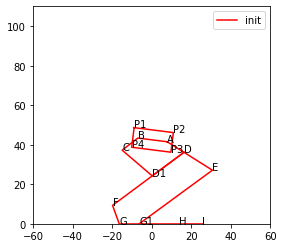

In [ ]:
#points_output,outputs = animate(states)    
points_output,rubber_outputs = animate(states) 

[2.0943951023931944]


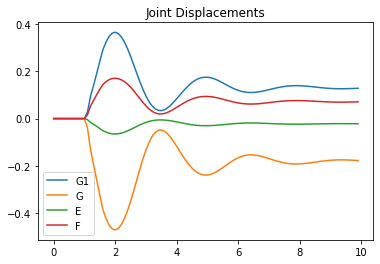

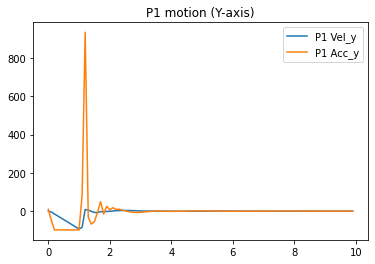

In [ ]:
analysis(rubber_outputs)

Figure 11: Rubber Joint Displacements and P1 Motion

2021-03-20 04:47:50,384 - pynamics.output - INFO - calculating outputs
2021-03-20 04:47:50,500 - pynamics.output - INFO - done calculating outputs


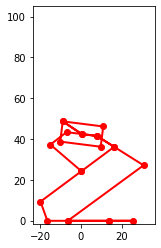

In [ ]:
# Save video
points_output = PointsOutput([pNPC,pNP1,pNP2,pNP3,pNP4,pNP1,pNPC,pNA,pND,pND1,pNC,pNB,pNA,pND,pNE,pNG1,pNH,pNI,pNH,pNG1,pNG,pNF,pND1],system)
points_output.calc(states)    
points_output.animate(fps,movie_name='Rubber_leg.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [ ]:
HTML(points_output.anim.to_html5_video())

### 4.2 Transparancy Film Simulation

In [ ]:
t = np.arange(0,tfinal,1/fps) # 30fps

# Initial conditions
states_init_d = qs1
states_init = []
for sv in state_variables:
    if sv in qs1:
        states_init.append(states_init_d[sv])
    else:
        states_init.append(0)

# Update system with transparancy spring and dampener coefficients
system.constant_values[b]=transparancy_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[k]=transparancy_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2

 # Update all other joints with transparancy spring and dampener coefficients
system.constant_values[bj]=transparancy_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[kj]=transparancy_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2

# Simulate       
f,ma = system.getdynamics()
f_s, f_c = system.state_space_post_invert(f,ma,eq_dd,return_lambda=True)
states = pynamics.integration.integrate(f_s,states_init,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-20 04:48:09,584 - pynamics.system - INFO - getting dynamic equations
2021-03-20 04:48:13,252 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-20 04:48:13,301 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-20 04:49:08,981 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-20 04:49:08,983 - pynamics.system - INFO - calculating function for lambdas
2021-03-20 04:49:08,986 - pynamics.integration - INFO - beginning integration
2021-03-20 04:49:08,987 - pynamics.system - INFO - integration at time 0000.00
2021-03-20 04:50:41,005 - pynamics.system - INFO - integration at time 0001.24
2021-03-20 04:52:13,005 - pynamics.system - INFO - integration at time 0001.57
2021-03-20 04:53:45,371 - pynamics.system - INFO - integration at time 0001.80
2021-03-20 04:55:17,945 - pynamics.system - INFO - integration at time 0002.24
2021-03-20 04:56:50,037 - pynamics.system - INFO - integration at time 0003.30
2021-03-20 04:58:22

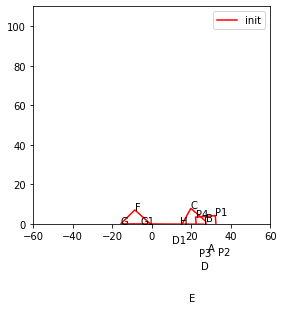

In [ ]:
points_output,transparancy_outputs = animate(states)    

[2.0943951023931944]


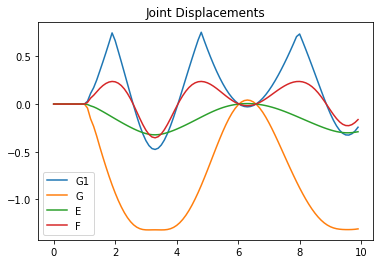

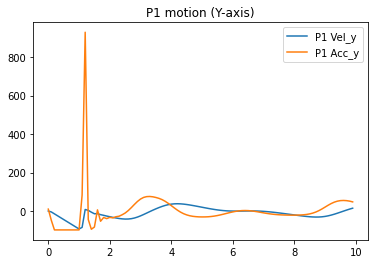

In [ ]:
analysis(transparancy_outputs)

Figure 12: Transparancy Film Displacements and P1 Motion

2021-03-20 05:05:58,711 - pynamics.output - INFO - calculating outputs
2021-03-20 05:05:58,815 - pynamics.output - INFO - done calculating outputs


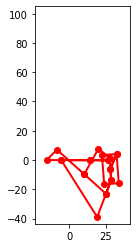

In [ ]:
# Save video
points_output = PointsOutput([pNPC,pNP1,pNP2,pNP3,pNP4,pNP1,pNPC,pNA,pND,pND1,pNC,pNB,pNA,pND,pNE,pNG1,pNH,pNI,pNH,pNG1,pNG,pNF,pND1],system)
points_output.calc(states)    
points_output.animate(fps,movie_name='Transparancy_leg.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [ ]:
HTML(points_output.anim.to_html5_video())

### 4.2 Polyuerthane Foam Simulation

In [ ]:
t = np.arange(0,tfinal,1/fps) # 30fps

# Initial conditions
states_init_d = qs1
states_init = []
for sv in state_variables:
    if sv in qs1:
        states_init.append(states_init_d[sv])
    else:
        states_init.append(0)

 # Update system with transparancy spring and dampener coefficients
system.constant_values[b]=polyuerthane_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[k]=polyuerthane_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2

 # Update all other joints with transparancy spring and dampener coefficients
system.constant_values[bj]=transparancy_properties["b"]*KG_TO_W*M_TO_L**2/S_TO_T
system.constant_values[kj]=transparancy_properties["k"]*KG_TO_W*M_TO_L**2/S_TO_T**2

# Simulate
f,ma = system.getdynamics()
f_s, f_c = system.state_space_post_invert(f,ma,eq_dd,return_lambda=True)
states = pynamics.integration.integrate(f_s,states_init,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-20 05:06:07,785 - pynamics.system - INFO - getting dynamic equations
2021-03-20 05:06:11,635 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-20 05:06:11,684 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-20 05:07:07,852 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-20 05:07:07,853 - pynamics.system - INFO - calculating function for lambdas
2021-03-20 05:07:07,859 - pynamics.integration - INFO - beginning integration
2021-03-20 05:07:07,864 - pynamics.system - INFO - integration at time 0000.00
2021-03-20 05:08:40,181 - pynamics.system - INFO - integration at time 0001.26
2021-03-20 05:10:12,525 - pynamics.system - INFO - integration at time 0001.45
2021-03-20 05:11:45,697 - pynamics.system - INFO - integration at time 0001.85
2021-03-20 05:13:18,992 - pynamics.system - INFO - integration at time 0002.47
2021-03-20 05:14:51,666 - pynamics.system - INFO - integration at time 0003.26
2021-03-20 05:16:24

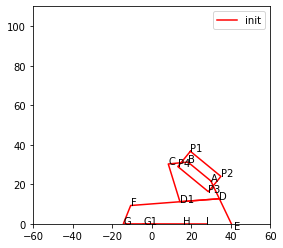

In [ ]:
points_output,polyuerthane_outputs = animate(states)    

[2.0943951023931944]


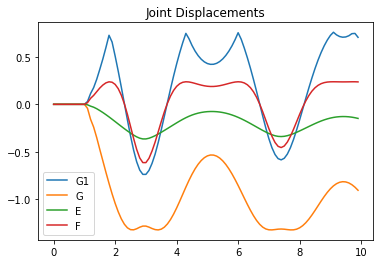

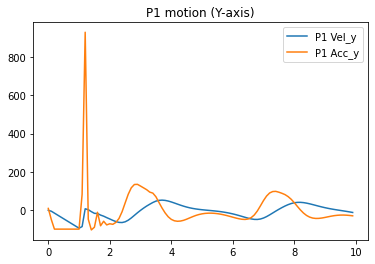

In [ ]:
analysis(polyuerthane_outputs)

Figure 13: Polyuerthane Film Displacements and P1 Motion

2021-03-20 05:21:36,771 - pynamics.output - INFO - calculating outputs
2021-03-20 05:21:36,880 - pynamics.output - INFO - done calculating outputs


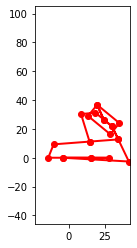

In [ ]:
# Save video
points_output = PointsOutput([pNPC,pNP1,pNP2,pNP3,pNP4,pNP1,pNPC,pNA,pND,pND1,pNC,pNB,pNA,pND,pNE,pNG1,pNH,pNI,pNH,pNG1,pNG,pNF,pND1],system)
points_output.calc(states)    
points_output.animate(fps,movie_name='Polyuerthane_leg.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [ ]:
HTML(points_output.anim.to_html5_video())

## **5. Discussion**

Using the optimized spring constant and damping constant for each material at the actuation joint, a simulation was run for three different models, no damper (transparent film, used in the other joints), polyurethane, and rubber. Of the three models, the rubber had the highest damping constant.

The results of the simulation for the polyurethane and no damper control were the models collapsing under their own weight. In contrast, the simulation for the rubber showed a stable landing. Based on these results, the team concludes the rubber material should be used at the actuation joint for the final prototype. This material should provide the best landing stability.

## **6. References**

[1] M. Smith, C. Brauer , R. Rossi, and F. Chen, “Background,” _mosmith3asu.github.io_, 07-Feb-2021. [Online]. Available: https://mosmith3asu.github.io/background. [Accessed: 20-Mar-2021]. 

[2] M. Smith, C. Brauer , R. Rossi, and F. Chen, “Kinematics,” _mosmith3asu.github.io_, 07-Feb-2021. [Online]. Available: https://mosmith3asu.github.io/kinematics. [Accessed: 20-Mar-2021]. 